# Segmentation sémantique avec Unet
![](https://www.cityscapes-dataset.com/wordpress/wp-content/uploads/2015/07/muenster00.png)

L'objectif de ce projet est de concevoir un modèle de segmentation d’images semantique. La segmentation sémantique est un algorithme de Deep Learning qui associe une catégorie à chaque pixel d'une image. Elle permet de reconnaître un ensemble de pixels qui forment des catégories distinctes.

Les images sont issues du jeux de données de [cityscape](https://www.cityscapes-dataset.com). Le nombre de categorie est réduit de 37 à 8.
  - void
  - flat
  - construction
  - object
  - nature
  - sky
  - human
  - vehicle


Dans ce notebook nous allons explorer un modèle **Unet** qui sera entrainé  avec une perte de type **Catégorical Cross Entropy** et avec une perte de type **Dice**.

## Calcul de la perte

### Dice loss
L’utilisation de l’entropie inter-catégorique comme calcul de perte ne donne pas de bon résultat car elle n’est pas assez précise au niveau de catégorisation des pixels. Le calcul de la perte avec le coefficient de Dice donne de meilleurs résultats avec des classes déséquilibrées.


## Modèle U-Net
Le modèle U-net a été proposé pour la première fois par : Olaf Ronneberger, Philipp Fischer et Thomas Brox dans leur article intitulé "U-Net: Convolutional Networks for Biomedical Image Segmentation". Le modèle U-net est construit sur le modèle FCN-8 pour s'adapter à l'imagerie médicale. 

![](https://miro.medium.com/max/1400/1*f7YOaE4TWubwaFF7Z1fzNw.png)

C'est un modèle symétrique en forme de U séparé par un bottleneck. La première partie appelée contraction ou downsampling effectue l'extraction des caractéristiques contextuelles, la deuxième partie est le bottleneck qui force le modèle à apprendre d'une compression des données d'entrée et la dernière partie (qui est l'inverse exact de la première partie) appelée expansion ou upsampling effectue la localisation des caractéristiques.
Un des avantages de ce modèle c'est qu'il est plus rapide qu'un modèle FCN.







# Chargement des bibliothèques

In [22]:
import tensorflow as tf
from keras import optimizers
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import gc
import random
from keras.utils.vis_utils import plot_model

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Mount Google drive
from google.colab import drive
import os
import sys

drive.mount("/content/drive", force_remount=True)
app_folder = '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/'


Mounted at /content/drive


## Chargement des modules complémentaires

In [25]:
# Copy modules
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Models' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Losses' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Metrics' .
!cp -r '/content/drive/MyDrive/AI Engineer/P8_Future-Vision-Transport/Lib/Dataset' .


In [26]:
%reload_ext autoreload
from Models import build_model
from Losses import LOSS_FACTORY
from Metrics import METRIC_FACTORY
from Dataset import get_data
from Dataset import categories
from Dataset import load_data
from Dataset import set_color_to_mask
from Dataset import data_generator
from Dataset.data_generator import data_generator
from Metrics.iou_coef import IoU


# Definition des variables

In [27]:
EPOCHS = 100
patience = 30
model_name = 'unet'
optimizer_name = 'adam'
n_classes = 8
input_height = 128
input_width = 256
BATCH_SIZE = 64


# Chargement des données

In [ ]:
# get Val data set frol google drive
get_data('gdrive',app_folder + '/data/', 'train')

In [29]:
# Load data into numpy array
imgs, masks = load_data('train', input_height,input_width, 3000)

In [30]:
print(f"{len(imgs)} images and {len(masks)} images mask")
print(f"Images properties: {np.array(imgs).shape}")
print(f"Masks properties: {np.array(masks).shape}")

2975 images and 2975 images mask
Images properties: (2975, 128, 256, 3)
Masks properties: (2975, 128, 256, 8)


## Exemple d'image

In [31]:
sns.color_palette("icefire", len(categories))

[(0.42110294, 0.69916972, 0.80506683),
 (0.2157176, 0.47827123, 0.81487615),
 (0.2659204, 0.25949691, 0.511417),
 (0.14254381, 0.14016944, 0.18944326),
 (0.19884415, 0.12394381, 0.1385669),
 (0.47151732, 0.17401641, 0.24610337),
 (0.78979746, 0.24694858, 0.22678822),
 (0.93850535, 0.52748892, 0.28242464)]

# Preparation du modèle U-Net

In [32]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(np.squeeze(imgs), np.squeeze(masks), test_size=0.25, random_state=63)
gc.collect()

104

## Construction du modèle

In [33]:
callbacks = [
  tf.keras.callbacks.EarlyStopping(
    monitor='loss', 
    patience=patience,
    verbose=1
  ),  
  tf.keras.callbacks.ReduceLROnPlateau('loss',
    factor=0.01,
    patience=int(patience / 2),
    verbose=1
  )
]

model = build_model('unet',n_classes,input_height=input_height,input_width=input_width)
loss_func  = LOSS_FACTORY['dice_loss']
model.compile(loss=loss_func,optimizer='adam', metrics=['accuracy',METRIC_FACTORY['iou_coef'], METRIC_FACTORY['dice_coef']])

# Entrainement du modèle

In [34]:
%%time
steps_per_epoch = X_train.shape[0] // BATCH_SIZE
validation_steps = X_test.shape[0] // BATCH_SIZE

history = model.fit(
    X_train,
    y_train,
    steps_per_epoch=steps_per_epoch,     
    validation_data=(X_test,y_test), 
    epochs=EPOCHS,
    verbose=2,
    callbacks=[callbacks]
)


Epoch 1/100
34/34 - 29s - loss: 0.3811 - accuracy: 0.3623 - iou_coef: 0.1863 - dice_coef: 0.3102 - val_loss: 0.3152 - val_accuracy: 0.4079 - val_iou_coef: 0.2425 - val_dice_coef: 0.3888
Epoch 2/100
34/34 - 7s - loss: 0.2947 - accuracy: 0.4249 - iou_coef: 0.2621 - dice_coef: 0.4135 - val_loss: 0.2708 - val_accuracy: 0.4166 - val_iou_coef: 0.2827 - val_dice_coef: 0.4392
Epoch 3/100
34/34 - 7s - loss: 0.2538 - accuracy: 0.5724 - iou_coef: 0.3350 - dice_coef: 0.4985 - val_loss: 0.2552 - val_accuracy: 0.5742 - val_iou_coef: 0.3693 - val_dice_coef: 0.5357
Epoch 4/100
34/34 - 7s - loss: 0.2297 - accuracy: 0.5981 - iou_coef: 0.3861 - dice_coef: 0.5538 - val_loss: 0.2278 - val_accuracy: 0.5881 - val_iou_coef: 0.3906 - val_dice_coef: 0.5590
Epoch 5/100
34/34 - 7s - loss: 0.2064 - accuracy: 0.6305 - iou_coef: 0.4073 - dice_coef: 0.5761 - val_loss: 0.1969 - val_accuracy: 0.6363 - val_iou_coef: 0.4322 - val_dice_coef: 0.6006
Epoch 6/100
34/34 - 7s - loss: 0.1873 - accuracy: 0.6654 - iou_coef: 0.421

## Evaluation du modèle

In [35]:
score = model.evaluate(X_test, y_test, verbose=1)


24/24 [==============================] - 1s 36ms/step - loss: 0.0879 - accuracy: 0.8474 - iou_coef: 0.7303 - dice_coef: 0.8403


In [36]:
print(f"Loss : {score[0]}")
print(f"Acuracy : {score[1]}")

Loss : 0.0879058837890625
Acuracy : 0.8473601937294006


In [37]:
gc.collect()

2661

## Exemples de prédictions

In [38]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(y_test, axis=3)

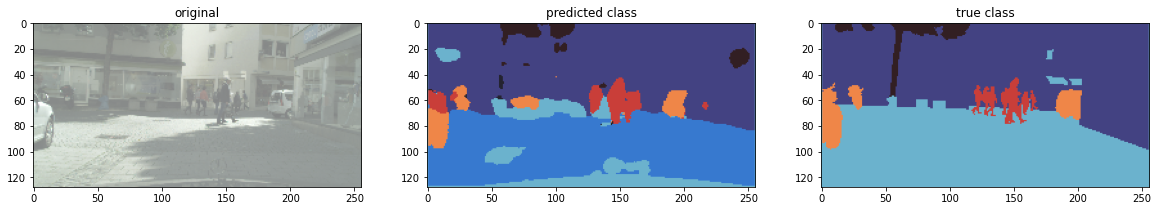

void          : 0.177
flat          : 0.000
construction  : 0.460
object        : 0.000
nature        : 0.284
sky           :  nan
human         : 0.335
vehicle       : 0.376

Mean IoU:  nan


/content/Metrics/iou_coef.py:23: RuntimeWarning: invalid value encountered in long_scalars
  IoU = intersection / combined_area


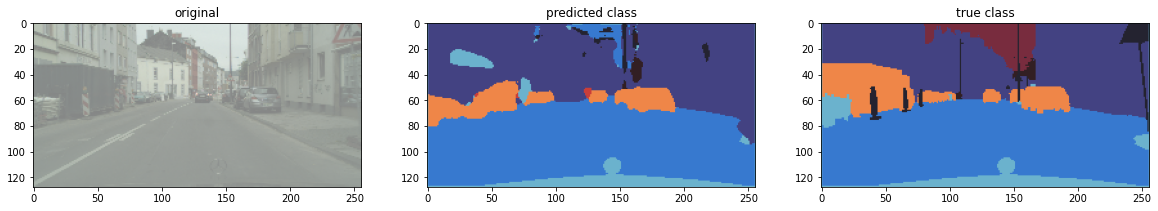

void          : 0.395
flat          : 0.483
construction  : 0.427
object        : 0.043
nature        : 0.306
sky           : 0.000
human         : 0.000
vehicle       : 0.287

Mean IoU: 0.243


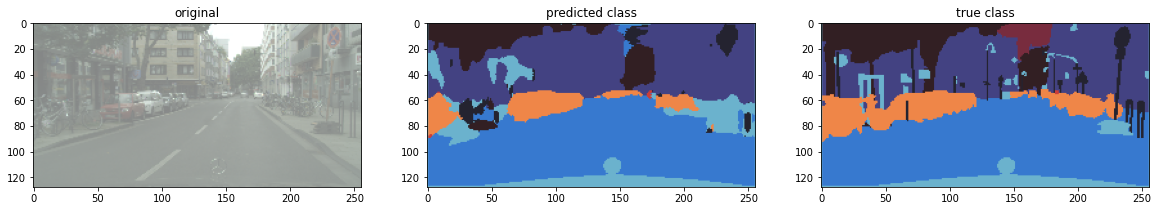

void          : 0.311
flat          : 0.483
construction  : 0.410
object        : 0.125
nature        : 0.381
sky           : 0.000
human         : 0.000
vehicle       : 0.341

Mean IoU: 0.256


13847

In [39]:
import random

random_images = random.sample(range(len(X_test)), 3)

for i in random_images:
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(20,40))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(set_color_to_mask(seg))
    ax.set_title("predicted class")
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(set_color_to_mask(segtest))
    ax.set_title("true class")
    plt.show()

    IoU(y_testi[i],y_predi[i],categories)
gc.collect()

# Conclusion
L'utilisation du calcul de la perte avec l'algothime Dice permet d'augmenter la précision, ainsi que le score IoU et Dice. 